# Metadata

```yaml
Course:  DS 5001
Module:  M03 Language Models
Topic:   How to Create an N-Gram Model from ScratchHow to Create an N-Gram Model from Scratch
Author:  R.C. Alvarado
Date:    6 February 2023
```

**Purpose**: To demonstrate how a simple ngram language models are created from data and applied to the prediction of sentences. No effort is made to define classes or functions; instead the code is meant to show the logic as clearly as possible.

# Set Up Environment

In [67]:
import pandas as pd
import numpy as np

# Get Some Training Data

In [2]:
data_dir = "../data/output"
OHCO = ['book_id','chap_num','para_num','sent_num','token_num']

In [77]:
TOKEN = pd.read_csv(data_dir + "/austen-combo-TOKENS.csv").set_index(OHCO)
VOCAB = pd.read_csv(data_dir + "/austen-combo-VOCAB.csv").set_index('term_str')

In [78]:
TOKEN.head()

token_str  term_str
book_id chap_num para_num sent_num token_num                    
1       1        1        0        0               The       the
                                   1            family    family
                                   2                of        of
                                   3          Dashwood  dashwood
                                   4               had       had

In [79]:
VOCAB.head()

,n,n_chars,p,i,h
term_str,,,,,
1,3,1,0.000015,16.058922,0.000235
15,1,2,0.000005,17.643884,0.000086
16,1,2,0.000005,17.643884,0.000086
1760,1,4,0.000005,17.643884,0.000086
1784,1,4,0.000005,17.643884,0.000086


# Select OOV terms

We select very short words that appear only once.

In [80]:
VOCAB['modifed_term_str'] = VOCAB.index
VOCAB.loc[(VOCAB.n == 1) & (VOCAB.n_chars < 3), 'modifed_term_str'] = "<UNK>"

In [81]:
VOCAB

,n,n_chars,p,i,h,modifed_term_str
term_str,,,,,,
1,3,1,0.000015,16.058922,0.000235,1
15,1,2,0.000005,17.643884,0.000086,<UNK>
16,1,2,0.000005,17.643884,0.000086,<UNK>
1760,1,4,0.000005,17.643884,0.000086,1760
1784,1,4,0.000005,17.643884,0.000086,1784
...,...,...,...,...,...,...
youthful,3,8,0.000015,16.058922,0.000235,youthful
z,1,1,0.000005,17.643884,0.000086,<UNK>
zeal,7,4,0.000034,14.836529,0.000507,zeal


We apply the modified term list to our tokens.

In [87]:
TOKEN['modifed_term_str'] = TOKEN.term_str.map(VOCAB.modifed_term_str)

In [88]:
TOKEN[TOKEN.modifed_term_str == '<UNK>'].sample(5)

token_str term_str  \
book_id chap_num para_num sent_num token_num                      
2       22       41       2        1                 n        n   
        1        2        0        8                15       15   
1       39       19       13       11                L        l   
2       21       71       4        13               Wm       wm   
        17       8        20       10               au       au   

                                             modifed_term_str  
book_id chap_num para_num sent_num token_num                   
2       22       41       2        1                    <UNK>  
        1        2        0        8                    <UNK>  
1       39       19       13       11                   <UNK>  
2       21       71       4        13                   <UNK>  
        17       8        20       10                   <UNK>

# Generate NGram Models

## Prepare tokens for ngram binding

First, we filter all tokens that start sentences.\
Our OHCO index helps us here: any token with  `token_num == 0` is at the start of a sentence, since the renumbering starts with each sentence.

In [10]:
S = TOKEN.query("token_num == 0")[['modifed_term_str']].index

We assign an absolute sentence number to each inital token and then label all the tokens in a given sentence by their sentence number. \
We must do this because the current `sent_num` index column refers to the order of the sentence within the paragraph. \
We want the order of the sentence within the corpus.

In [11]:
TOKEN.loc[S, 'sent_num2'] = [n+1 for n in range(len(S))] # Assign ordinals 

In [12]:
TOKEN.sent_num2 = TOKEN.sent_num2.ffill().astype('int') # Label all members of sentence with ordinal

Then we prepend each sentence with the `<s>` sign.

In [13]:
TOKEN2 = TOKEN.groupby('sent_num2').modifed_term_str\
    .apply(lambda x: pd.Series(['<s>'] + list(x))).reset_index(drop=True)

Inspect the results:

In [14]:
' '.join(TOKEN2.head(20).to_list()) + ' ...'

'<s> the family of dashwood had long been settled in sussex <s> their estate was large and their residence was ...'

## Bind modified token sequence into an ngram table 

Next, we choose the maximum ngram length for our models.

In [15]:
ngram = 3

Now we concatenate a set of offset versions of our token list. \
For this we use the `pd.concat()` method to bind our token lists, and \
we use the `df.shift()` method to offset our token list for each position in the resulting ngram list.

In [16]:
NGRAMS = pd.concat([TOKEN2.shift(0-i) for i in range(ngram)], axis=1)

We create our word index names following the convention `w0, w1, ..., wN`.

In [17]:
widx = [f"w{i}" for i in range(ngram)]
NGRAMS.columns = widx

## Generate models

Next we create a list of models. \
Since the model index will be zero-based (given Python), the trigram model will be `M[2]`, for example. \
We can use the maximum ngram table to derive all of the lower order models.

For each model, we will compute the relevant probabilities and information for each ngram.

In [18]:
M = [None for i in range(ngram)]
for i in range(ngram):
    if i == 0:
        M[i] = NGRAMS.value_counts('w0').to_frame('n')
        M[i]['p'] = M[i].n / M[i].n.sum()
        M[i]['i'] = np.log2(1/M[i].p)
    else:
        M[i] = NGRAMS.value_counts(widx[:i+1]).to_frame('n')    
        M[i]['cp'] = M[i].n / M[i-1].n
        M[i]['ci'] = np.log2(1/M[i].cp)

In [19]:
M[2]

n        cp        ci
w0        w1          w2                               
mrs       <s>         jennings  234  0.442344  1.176759
<s>       it          was       177  0.407834  1.293946
          i           am        142  0.142714  2.808806
                      have      132  0.132663  2.914159
mrs       <s>         dashwood  121  0.228733  2.128261
...                             ...       ...       ...
happy     as          all         1  0.333333  1.584963
                      to          1  0.333333  1.584963
                      we          1  0.333333  1.584963
          at          bath        1  0.333333  1.584963
zealously discharging all         1  1.000000  0.000000

[167053 rows x 3 columns]

# Test Models

## Generate Training Data

Import and pad the test sentences.

In [20]:
TEST_SENTS = pd.read_csv("test_sentences.txt", header=None, names=['sent_str'])
TEST_SENTS.sent_str = '<s> ' + TEST_SENTS.sent_str 
TEST_SENTS.index.name = 'sent_num'

In [21]:
TEST_SENTS.head()

,sent_str
sent_num,
0,<s> the quick brown fox jumped over the lazy dogs
1,<s> The event had every promise of happiness f...
2,<s> Mr Weston was a man of unexceptionable cha...
3,<s> ChatGPT is not the singularity
4,<s> but it was a black morning's work for her


Tokenize and normalize.

In [22]:
TEST_TOKENS = TEST_SENTS.sent_str.apply(lambda x: pd.Series(x.split())).stack().to_frame('token_str')
TEST_TOKENS['term_str'] = TEST_TOKENS.token_str.str.replace(r"[\W_]+", "", regex=True).str.lower()
TEST_TOKENS.index.names = ['sent_num', 'token_num']
TEST_TOKENS.loc[TEST_TOKENS.token_str == '<s>', 'term_str'] = '<s>'

In [23]:
TEST_TOKENS.head()

token_str term_str
sent_num token_num                   
0        0               <s>      <s>
         1               the      the
         2             quick    quick
         3             brown    brown
         4               fox      fox

## Identify OOV terms

In [24]:
V = M[0].sort_index().reset_index().w0.to_list()

In [25]:
V[:10]

['1', '1760', '1784', '1785', '1787', '1789', '1791', '1800', '1803', '1806']

In [26]:
TEST_TOKENS.loc[~TEST_TOKENS.term_str.isin(V), 'term_str'] = "<UNK>"

In [27]:
OOV = TEST_TOKENS[TEST_TOKENS.term_str == '<UNK>'].value_counts('token_str')

In [28]:
OOV

token_str
Weston            2
ChatGPT           1
Hartfield         1
Isabella          1
Isabella's        1
Woodhouse         1
childhood         1
illnesses         1
intellectual      1
lazy              1
tenderer          1
valetudinarian    1
dtype: int64

## Convert test tokens into ngrams

Use offset and bind method, as above.

In [29]:
TEST = pd.concat([TEST_TOKENS.shift(0-i)[['term_str']] for i in range(ngram)], axis=1).fillna('<s>')
TEST.columns = widx
TEST = TEST.reset_index()

## Bind the models to test data

In [30]:
TEST = TEST.merge(M[0].i, on=['w0'], how='left').rename(columns={'i':'i0'})
TEST = TEST.merge(M[1].ci, on=['w0','w1'], how='left').rename(columns={'ci':'i1'})
TEST = TEST.merge(M[2].ci, on=['w0','w1','w2'], how='left').rename(columns={'ci':'i2'})

In [31]:
TEST

,sent_num,token_num,w0,w1,w2,i0,i1,i2
0,0,0,<s>,the,quick,4.079031,4.692843,NaN
1,0,1,the,quick,brown,4.871565,12.860311,NaN
2,0,2,quick,brown,fox,13.483948,NaN,NaN
3,0,3,brown,fox,jumped,15.731876,NaN,NaN
4,0,4,fox,jumped,over,17.731876,NaN,NaN
...,...,...,...,...,...,...,...,...
474,42,10,give,her,pleasant,10.052396,2.979040,NaN
475,42,11,her,pleasant,society,5.860356,NaN,NaN
476,42,12,pleasant,society,again,12.924521,NaN,NaN
477,42,13,society,again,<s>,12.522422,NaN,NaN


## Apply fallback

Note that some values are null -- these are cases of ngram combinations that do not appear in the training data.

We we replace null values using "stupid fallback."

In [32]:
TEST.loc[TEST.i1.isna(), 'i1'] = TEST.w1.map(M[0].i)

In [33]:
TEST = TEST.merge(M[1].ci, left_on=['w1','w2'], right_on=['w0','w1'])
TEST.loc[TEST.i2.isna(), 'i2'] = TEST.ci
TEST = TEST.drop('ci', axis=1)

In [34]:
TEST.sort_values('i0')

,sent_num,token_num,w0,w1,w2,i0,i1,i2
0,0,0,<s>,the,quick,4.079031,4.692843,12.860311
120,12,0,<s>,the,equal,4.079031,4.692843,12.860311
247,29,0,<s>,he,could,4.079031,4.546936,5.520946
112,11,0,<s>,but,the,4.079031,3.860055,4.207828
310,39,0,<s>,being,settled,4.079031,13.652845,7.588715
...,...,...,...,...,...,...,...,...
31,3,5,singularity,<s>,but,17.731876,4.079031,3.860055
102,9,3,nursed,her,through,17.731876,0.000000,10.871520
111,10,7,owing,here,<s>,17.731876,10.777680,2.494765
207,22,2,emma,was,aware,17.731876,6.088922,11.642954


## Compute sentence scores

In [35]:
for n in range(ngram):
    TEST_SENTS[f'pp{n}'] = np.exp2(TEST.groupby('sent_num')[f'i{n}'].mean())

In [36]:
TEST_SENTS.sort_values('pp0')

,sent_str,pp0,pp1,pp2
sent_num,,,,
28,<s> but he was no companion for her,145.357489,26.750415,18.182994
4,<s> but it was a black morning's work for her,148.604344,18.804570,10.627530
20,<s> How was she to bear the change,174.535449,121.731770,46.475659
15,<s> knowing all the ways of the family,203.953006,78.587207,15.825995
24,<s> and a Miss Taylor in the house,216.447123,19.738968,40.828353
19,<s> and who had such an affection for her as c...,295.448369,55.405022,34.042184
25,<s> and with all her advantages natural and do...,327.764932,27.775828,53.561982
18,<s> one to whom she could speak every thought ...,333.071762,87.041195,45.592410
14,<s> She had been a friend and companion such a...,344.042445,27.441608,64.904077


In [37]:
TEST_SENTS.sort_values('pp1')

,sent_str,pp0,pp1,pp2
sent_num,,,,
4,<s> but it was a black morning's work for her,148.604344,18.804570,10.627530
24,<s> and a Miss Taylor in the house,216.447123,19.738968,40.828353
28,<s> but he was no companion for her,145.357489,26.750415,18.182994
14,<s> She had been a friend and companion such a...,344.042445,27.441608,64.904077
25,<s> and with all her advantages natural and do...,327.764932,27.775828,53.561982
27,<s> She dearly loved her father,663.007460,28.602197,28.635560
30,<s> The evil of the actual disparity in their ...,1223.107682,31.453894,42.647237
3,<s> ChatGPT is not the singularity,8600.974183,31.931518,13.392683
29,<s> He could not meet her in conversation rati...,378.803852,38.265340,49.526003


In [38]:
TEST_SENTS.sort_values('pp2')

,sent_str,pp0,pp1,pp2
sent_num,,,,
4,<s> but it was a black morning's work for her,148.604344,18.804570,10.627530
23,<s> only half a mile from them,394.857522,46.774769,10.894267
3,<s> ChatGPT is not the singularity,8600.974183,31.931518,13.392683
15,<s> knowing all the ways of the family,203.953006,78.587207,15.825995
16,<s> interested in all its concerns,776.267181,185.024593,16.641468
28,<s> but he was no companion for her,145.357489,26.750415,18.182994
26,<s> she was now in great danger of suffering f...,512.034623,135.537903,18.431472
11,<s> but the intercourse of the last seven years,418.395208,48.587161,20.959605
36,<s> and though everywhere beloved for the frie...,594.856684,52.417671,26.516313


# Visualize

In [65]:
Z = TEST_SENTS.copy()
Z['sent_str'] = Z.sent_str.str.replace('<s> ', '')
Z = Z.set_index('sent_str')
Z = (Z - Z.mean()) / Z.std()
Z['pp_mean'] = Z.mean(axis=1)

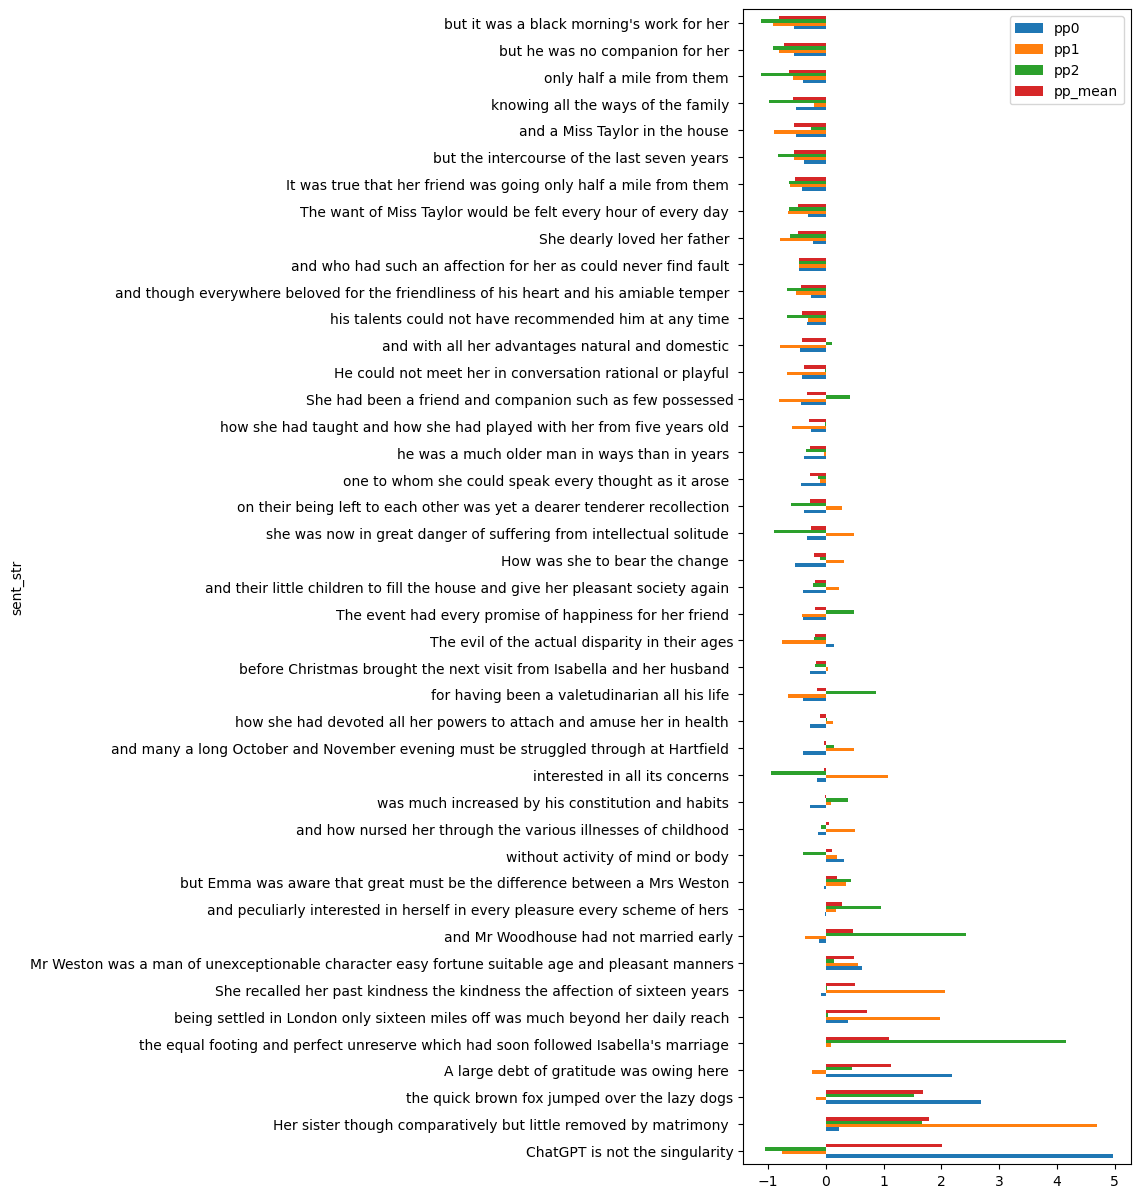

In [66]:
Z.sort_values('pp_mean', ascending=False).plot.barh(figsize=(5,15));

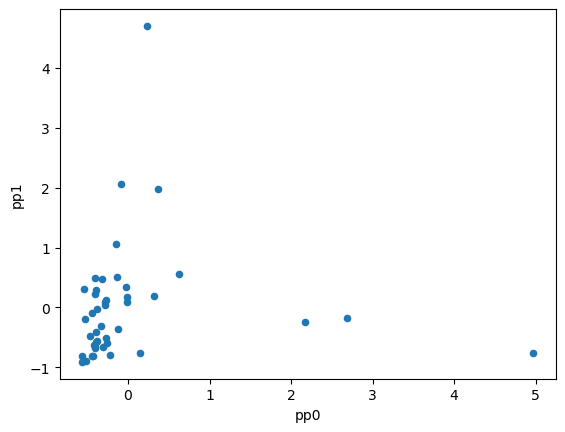

In [60]:
Z.plot.scatter('pp0', 'pp1');

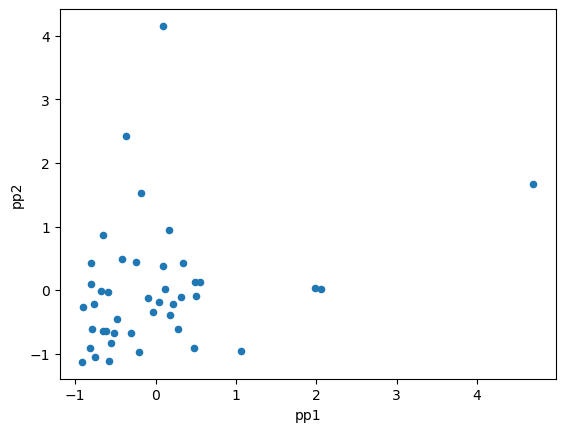

In [61]:
Z.plot.scatter('pp1', 'pp2');

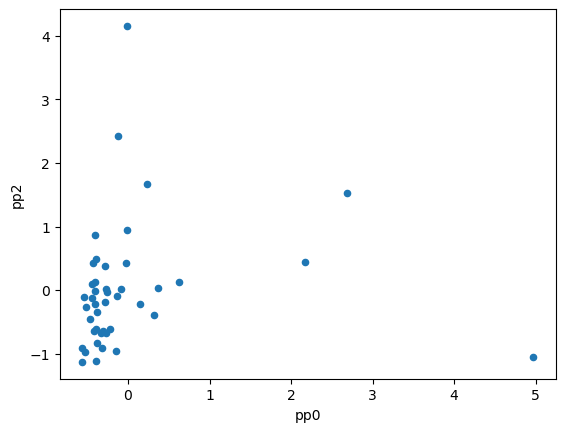

In [62]:
Z.plot.scatter('pp0', 'pp2');